In [11]:
import numpy as np

from pysensors.optimizers._qr import QR

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pysensors as ps
from matplotlib.patches import Circle


In [12]:
faces = datasets.fetch_olivetti_faces(shuffle=True)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
nx = 64
ny = 64

Number of samples: 400
Number of features (sensors): 4096


In [13]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                interpolation='nearest',
                vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

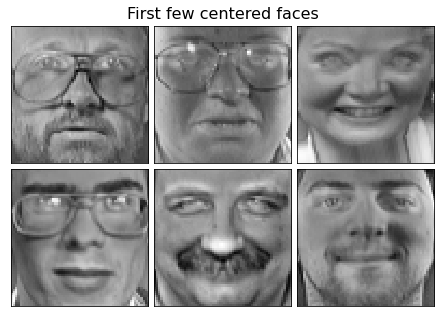

In [14]:
plot_gallery("First few centered faces", X[:n_components])

In [15]:
#Find all sensor locations using built in QR optimizer
#max_const_sensors = 230
#n_const_sensors = 2
n_sensors = 20
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(optimizer=optimizer, n_sensors=n_sensors)
model.fit(X)

all_sensors = model.get_all_sensors()
top_sensors0 = model.get_selected_sensors()
print(top_sensors0)
#print('Unconstrained Optimal sensors, n = {}, {},...'.format(len(all_sensors),all_sensors[:n_sensors+3]))
#print('Unconstrained Optimal sensors, n = {}, {}'.format(len(top_sensors0),top_sensors0))

[4032  384 4092 4039  447  493 2204  657  878 2880 1088 4087 2837 3779
 3093 2395  581 2751 1023 2970]


In [16]:
##Constrained sensor location on the grid: 
# xmin = 20
# xmax = 40
# ymin = 25
# ymax = 45
# sensors_constrained = ps.optimizers._gqr.getConstraindSensorsIndices(xmin,xmax,ymin,ymax,nx,ny,all_sensors) #Constrained column indices
# print('The constrained sensors are {}'.format(sensors_constrained))
# print('The constrained sensors are {}'.format(top_sensors0[np.isin(top_sensors0,sensors_constrained,invert=False)]))

In [17]:
def distance_constraints_indices(r,nx,ny,piv,n_sensors,j): ##Need to combine all the idx_constrained 
    
    n_features = len(all_sensors)

    a = np.unravel_index(piv, (nx,ny))
    x_cord = a[0][j-1]
    y_cord = a[1][j-1]
    #print(x_cord, y_cord)
    constrained_sensorsx = []
    constrained_sensorsy = []
    for i in range(n_features):
        if ((a[0][i]-x_cord)**2 + (a[1][i]-y_cord)**2) < r**2: 
            #print(a[0][i],a[1][i])
            constrained_sensorsx.append(a[0][i])
            constrained_sensorsy.append(a[1][i])
    #print(constrained_sensorsx, constrained_sensorsy)
    constrained_sensorsx = np.array(constrained_sensorsx)
    constrained_sensorsy = np.array(constrained_sensorsy)
    constrained_sensors_array = np.stack((constrained_sensorsy, constrained_sensorsx), axis=1)
    constrained_sensors_tuple = np.transpose(constrained_sensors_array)
    idx_constrained = np.ravel_multi_index(constrained_sensors_tuple, (nx,ny))
        #print(idx_constrained)
    return idx_constrained

In [18]:
def f_region_distance_constraints(r,nx,ny,all_sensors, dlens, piv, j,n_sensors):
    if j == 0:
        return dlens
    else:
    
        idx_constrained = distance_constraints_indices(r,nx,ny,piv,n_sensors,j)
        didx = np.isin(piv[j:],idx_constrained,invert=False)
        dlens[didx] = 0
        return dlens


In [19]:
class AQR(QR):
    """
    General QR optimizer for sensor selection.
    Ranks sensors in descending order of "importance" based on
    reconstruction performance. This is an extension that requires a more intrusive
    access to the QR optimizer to facilitate a more adaptive optimization. This is a generalized version of cost constraints
    in the sense that users can allow n constrained sensors in the constrained area.
    if n = 0 this converges to the CCQR results.

    See the following reference for more information
        Manohar, Krithika, et al.
        "Data-driven sparse sensor placement for reconstruction:
        Demonstrating the benefits of exploiting known patterns."
        IEEE Control Systems Magazine 38.3 (2018): 63-86.

    @ authors: Niharika Karnik (@nkarnik2999), Mohammad Abdo (@Jimmy-INL), and Krithika Manohar (@kmanohar)
    """
    def __init__(self,n_sensors,all_sensors,r,nx,ny):
        """
        Attributes
        ----------
        pivots_ : np.ndarray, shape [n_features]
            Ranked list of sensor locations.
        idx_constrained : np.ndarray, shape [No. of constrained locations]
            Column Indices of the sensors in the constrained locations.
        n_sensors : integer, 
            Total number of sensors
        const_sensors : integer,
            Total number of sensors required by the user in the constrained region.
        """
        self.pivots_ = None
        self.nSensors = n_sensors
        self.all_sensorloc = all_sensors
        self.radius = r
        self._nx = nx
        self._ny = ny


    def fit(
        self,
        basis_matrix
    ):
        """
        Parameters
        ----------
        basis_matrix: np.ndarray, shape [n_features, n_samples]
            Matrix whose columns are the basis vectors in which to
            represent the measurement data.
        optimizer_kws: dictionary, optional
            Keyword arguments to be passed to the qr method.

        Returns
        -------
        self: a fitted :class:`pysensors.optimizers.QR` instance
        """

        n_features, n_samples = basis_matrix.shape  # We transpose basis_matrix below
        #max_const_sensors = len(self.constrainedIndices) #Maximum number of sensors allowed in the constrained region

        ## Assertions and checks:
        #if self.nSensors > n_features - max_const_sensors + self.nConstrainedSensors:
            #raise IOError ("n_sensors cannot be larger than n_features - all possible locations in the constrained area + allowed constrained sensors")
        #if self.nSensors > n_samples + self.nConstrainedSensors: ## Handling zero constraint?
            #raise IOError ("Currently n_sensors should be less than number of samples + number of constrained sensors,\
                           #got: n_sensors = {}, n_samples + const_sensors = {} + {} = {}".format(n_sensors,n_samples,self.nConstrainedSensors,n_samples+self.nConstrainedSensors))

        # Initialize helper variables
        R = basis_matrix.conj().T.copy()
        p = np.arange(n_features)
        k = min(n_samples, n_features)


        for j in range(k):
            r = R[j:, j:]
            # Norm of each column 
            dlens = np.sqrt(np.sum(np.abs(r) ** 2, axis=0))
            # if j != 0:
            #     dlens_old = dlens_updated
            # else:
            #     dlens_old = dlens
            dlens_updated = f_region_distance_constraints(self.radius,self._nx,self._ny,self.all_sensorloc,dlens,p,j,self.nSensors) #Handling constrained region sensor placement problem
            print(dlens_updated)
            # Choose pivot
            i_piv = np.argmax(dlens_updated)
          
            dlen = dlens_updated[i_piv]

            if dlen > 0:
                u = r[:, i_piv] / dlen
                u[0] += np.sign(u[0]) + (u[0] == 0)
                u /= np.sqrt(abs(u[0]))
            else:
                u = r[:, i_piv]
                u[0] = np.sqrt(2)

            # Track column pivots
            i_piv += j # true permutation index is i_piv shifted by the iteration counter j
            p[[j, i_piv]] = p[[i_piv, j]]

            # Switch columns
            R[:, [j, i_piv]] = R[:, [i_piv, j]]

            # Apply reflector
            R[j:, j:] -= np.outer(u, np.dot(u, R[j:, j:]))
            R[j + 1 :, j] = 0

        self.pivots_ = p


        return self

In [20]:

# def f_region_updated(lin_idx, dlens, piv, j, const_sensors,all_sensors,n_sensors):
#     counter = 0
#     mask = np.isin(all_sensors,lin_idx,invert=False)
#     const_idx = all_sensors[mask]
#     updated_lin_idx = const_idx[const_sensors:]
#     var = np.isin(all_sensors[:n_sensors],lin_idx, invert=False)
#     n = np.count_nonzero(var)
#     print(n)


#     if any(var) == False: #f_region
#         if j < const_sensors:
#             didx = np.isin(piv[j:],lin_idx,invert=True)
#             dlens[didx] = 0
#         else:
#             didx = np.isin(piv[j:],lin_idx,invert=False)
#             dlens[didx] = 0

#     elif n >= const_sensors: #f_region_optimal
#         for i in range(n_sensors):
#             if np.isin(all_sensors[i],lin_idx,invert=False):
#                 counter += 1
#                 if counter < const_sensors:
#                     dlens = dlens
#             else:
#                 didx = np.isin(piv[j:],updated_lin_idx,invert=False)
#                 dlens[didx] = 0

#     elif n < const_sensors:
#         for i in range(n_sensors):
#             if np.isin(all_sensors[i],lin_idx,invert=False):
#                 counter += 1
#                 if counter <= n:
#                     dlens = dlens

#                 elif n <= counter and counter <= const_sensors:
                       
#                         didx = np.isin(piv[j:],updated_lin_idx,invert=True)
#                         dlens[didx] = 0
#                 else:
#                     didx = np.isin(piv[j:],updated_lin_idx,invert=False)
#                     dlens[didx] = 0

#     return dlens

In [21]:
r = 7
optimizer1 = AQR(n_sensors,all_sensors,r,nx,ny)
model1 = ps.SSPOR(optimizer = optimizer1, n_sensors = n_sensors)
model1.fit(X)
all_sensors1 = model1.get_all_sensors()

top_sensors = model1.get_selected_sensors()


[3.6017013 3.6861243 3.727096  ... 3.9694474 3.9748106 3.9125938]
[3.6794097 3.7269068 3.659267  ... 3.5900235 3.5550506 3.5148866]
[0.        0.        0.        ... 3.4743278 3.474582  3.4667015]
[2.3921647 2.5788512 2.503426  ... 0.        0.        0.       ]
[2.5788503 2.503206  2.3640764 ... 1.5378283 2.2126265 2.4511552]
[2.5018702 2.3617132 2.184639  ... 1.5358236 2.2115734 2.4462159]
[2.3566432 2.176875  2.1142955 ... 1.5334948 2.2102485 2.4421096]
[2.1710463 2.1073353 2.097805  ... 1.5333759 2.2071729 2.4398267]
[2.1067212 2.0942876 1.9758159 ... 1.5311309 2.1878667 2.397034 ]
[2.0298548 1.9058006 1.8077422 ... 1.5309378 2.1792343 2.3901227]
[1.9054062 1.807664  1.752511  ... 1.5305661 2.1783564 2.3889356]
[0.        0.        0.        ... 1.5304997 2.1783414 2.3889267]
[1.7234247 1.6798127 1.6634132 ... 1.5304755 2.1781015 2.3888662]
[1.6790587 1.6625779 1.6555233 ... 1.5294378 2.177765  2.388849 ]
[1.6624212 1.6548581 1.6589171 ... 1.5277767 2.1777494 2.388558 ]
[1.6530648

[4032  384 4092 4039  493  575 2204  657  878 2880 1088 4087 2837 3779
 3093 2395  581 2751 2010 3039]


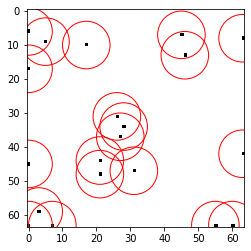

In [22]:
## TODO: this can be done using ravel and unravel more elegantly
img = np.zeros(n_features)
img[top_sensors] = 16
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
#plt.plot([xmin,xmin],[ymin,ymax],'r')
#plt.plot([xmin,xmax],[ymax,ymax],'r')
#plt.plot([xmax,xmax],[ymin,ymax],'r')
#plt.plot([xmin,xmax],[ymin,ymin],'r')
#plt.imshow(img.reshape(image_shape),cmap=plt.cm.binary)
# #plt.title('n_sensors = {}, n_constr_sensors = {}'.format(n_sensors,n_const_sensors))
print(top_sensors)
top_sensors_grid = np.unravel_index(top_sensors, (nx,ny))
# figure, axes = plt.subplots()
for i in range(len(top_sensors_grid[0])):
    circ = Circle( (top_sensors_grid[1][i], top_sensors_grid[0][i]), r ,color='r',fill = False )
    ax.add_patch(circ)
plt.show()

In [23]:
print(top_sensors0)
c = np.zeros([len(top_sensors0),n_features])
print(c.shape)
for i in range(len(top_sensors0)):
    c[i,top_sensors0[i]] = 1
phi = model.basis_matrix_
optimality = np.linalg.det((c@phi).T @ (c@phi))
print(optimality)

[4032  384 4092 4039  447  493 2204  657  878 2880 1088 4087 2837 3779
 3093 2395  581 2751 1023 2970]
(20, 4096)
0.0


In [24]:
print(top_sensors)
c1 = np.zeros([len(top_sensors),n_features])
print(c1.shape)
for i in range(len(top_sensors)):
    c1[i,top_sensors[i]] = 1
phi1 = model1.basis_matrix_
optimality1 = np.linalg.det((c1@phi1).T @ (c1@phi1))
print(optimality1)

[4032  384 4092 4039  493  575 2204  657  878 2880 1088 4087 2837 3779
 3093 2395  581 2751 2010 3039]
(20, 4096)
0.0


In [25]:
test_sensors = [4032, 384, 4092, 4039, 447, 493, 657, 878, 2880, 1088]

In [26]:
np.linalg.norm((X - model1.predict(X[:,top_sensors0])))/np.linalg.norm(X)

0.86233765

In [27]:
max_const_sensors = 1280
n_const_sensors0 = 3
n_sensors0 = 7
n_modes0 = 10
basis1 = ps.basis.SVD(n_basis_modes=n_modes0)
optimizer_faces = ps.optimizers.QR()
model = ps.SSPOR(basis=basis1,optimizer=optimizer_faces, n_sensors=n_sensors0)
model.fit(XX)

all_sensors0 = model.get_all_sensors()
top_sensors0 = model.get_selected_sensors()

NameError: name 'XX' is not defined

In [ ]:
np.linalg.norm((X - model1.predict(X[:,top_sensors])))/np.linalg.norm(X)

0.79669476

In [ ]:
np.linalg.norm((X - model1.predict(X[:,test_sensors])))/np.linalg.norm(X)

0.88171

In [ ]:
test_sensors2  = [x for x in all_sensors if x not in sensors_constrained][n_const_sensors:n_sensors]

In [ ]:
np.linalg.norm((X - model1.predict(X[:,test_sensors2])))/np.linalg.norm(X)

ValueError: x has the wrong number of features: 8.
                Expected 10

In [ ]:
XX = np.zeros_like(X)
XX[:,top_sensors] = X[:,top_sensors]
model1.score(XX)

-0.0730837